In [1]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)  


f:\PINN


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG
from src2.sampling import (
    sample_domain_points,
    sample_boundary_points,
    sample_interface_points,
    sample_substrate_far_boundary
)
from src2.losses import total_loss
from src2.pde_residuals import *
from src2.boundary_conditions import *


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
net1, net2, net3 = get_all_networks()
net1.to(DEVICE)
net2.to(DEVICE)
net3.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=2, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]
p1 = CONFIG["FGPM"]
p2 = CONFIG["HYDROGEL"]
p3 = CONFIG["SUBSTRATE"]


# Optimizer

In [6]:
optimizer = optim.Adam(
    list(net1.parameters()) +
    list(net2.parameters()) +
    list(net3.parameters()),
    lr=1e-3
)


# Training Loop (Simple + Transparent)

In [ ]:
for epoch in range(1, 100):

    xyt1, xyt2, xyt3 = sample_domain_points(4000, geom)
    xt_top = sample_boundary_points(1000, geom)
    xyt_i1, xyt_i2 = sample_interface_points(1000, geom)
    xyt_far_sub = sample_substrate_far_boundary(1000, geom)


    optimizer.zero_grad()

    loss, logs = total_loss(
        net1, net2, net3,
        xyt1, xyt2, xyt3,
        xt_top,
        xyt_i1,
        xyt_i2,
        xyt_far_sub,
        p1, p2, p3,
        electrically_open=True,
        w_far=1.0 
    )

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
      print(
        f"Epoch {epoch} | "
        f"Loss={loss.item():.3e} | "
        f"PDE={logs['pde']:.2e} | "
        f"BC={logs['bc_top']:.2e} | "
        f"Int1={logs['interface_1']:.2e} | "
        f"Int2={logs['interface_2']:.2e} | "
        f"Far={logs['far']:.2e}"
    )



Epoch 20 | Loss=1.790e+00 | PDE=1.00e+00 | BC=1.70e-07 | Int1=5.47e-03 | Int2=1.03e-02 | Far=2.45e-03
Epoch 40 | Loss=1.148e+00 | PDE=1.00e+00 | BC=4.69e-08 | Int1=2.75e-03 | Int2=1.77e-04 | Far=1.86e-03
Epoch 60 | Loss=1.035e+00 | PDE=1.00e+00 | BC=1.22e-08 | Int1=6.02e-04 | Int2=5.51e-05 | Far=1.69e-03
Epoch 80 | Loss=1.004e+00 | PDE=1.00e+00 | BC=4.64e-09 | Int1=3.71e-05 | Int2=1.54e-05 | Far=1.59e-03


In [8]:
import torch

torch.save({
    "net1": net1.state_dict(),
    "net2": net2.state_dict(),
    "net3": net3.state_dict()
}, "three_layer_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [9]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

h1 = geom["h1"]
h2 = geom["h2"]
h3 = geom["h3"]

y0 = 0.6
t0 = 0.6


Create a point in each layer

In [10]:
x_fgpm = torch.linspace(-h1, 0, 200).reshape(-1,1)
x_hydro = torch.linspace(0, h2, 200).reshape(-1,1)
x_sub = torch.linspace(h2, h3, 200).reshape(-1,1)

y_fgpm = torch.full_like(x_fgpm, y0)
t_fgpm = torch.full_like(x_fgpm, t0)

y_hydro = torch.full_like(x_hydro, y0)
t_hydro = torch.full_like(x_hydro, t0)

y_sub = torch.full_like(x_sub, y0)
t_sub = torch.full_like(x_sub, t0)


Feed to model

In [11]:
with torch.no_grad():
    w1, phi1 = net1(torch.cat([x_fgpm,y_fgpm,t_fgpm],dim=1).to(DEVICE)).split(1,1)
    w2, phi2 = net2(torch.cat([x_hydro,y_hydro,t_hydro],dim=1).to(DEVICE)).split(1,1)
    w3, phi3 = net3(torch.cat([x_sub,y_sub,t_sub],dim=1).to(DEVICE)).split(1,1)


Plot Displacement & Electrical Potential

In [12]:
# x0 = torch.tensor([[0.0, y0, t0]]).to(DEVICE)

# w1_0, phi1_0 = net1(x0).split(1,1)
# w2_0, phi2_0 = net2(x0).split(1,1)

# print("Jump in w at x=0:", (w1_0 - w2_0).item())
# print("Jump in phi at x=0:", (phi1_0 - phi2_0).item())

# xh2 = torch.tensor([[h2, y0, t0]]).to(DEVICE)

# w2_h, phi2_h = net2(xh2).split(1,1)
# w3_h, phi3_h = net3(xh2).split(1,1)

# print("Jump in w at x=h2:", (w2_h - w3_h).item())
# print("Jump in phi at x=h2:", (phi2_h - phi3_h).item())



In [13]:
# x_all = torch.cat([x_fgpm, x_hydro, x_sub], dim=0).cpu()
# w_all = torch.cat([w1, w2, w3], dim=0).cpu()

# # sort by x
# idx = torch.argsort(x_all.squeeze())
# x_all = x_all[idx]
# w_all = w_all[idx]


In [14]:
# phi_all = torch.cat([phi1, phi2, phi3], dim=0).cpu()
# phi_all = phi_all[idx]


In [15]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(x_all, w_all, 'b')
# plt.axvline(0, color='k', linestyle='--', alpha=0.5)
# plt.axvline(h2, color='k', linestyle='--', alpha=0.5)
# plt.title("Displacement w(x)")
# plt.xlabel("x")
# plt.grid()

# plt.subplot(1,2,2)
# plt.plot(x_all, phi_all, 'r')
# plt.axvline(0, color='k', linestyle='--', alpha=0.5)
# plt.axvline(h2, color='k', linestyle='--', alpha=0.5)
# plt.title("Electric Potential φ(x)")
# plt.xlabel("x")
# plt.grid()

# plt.show()


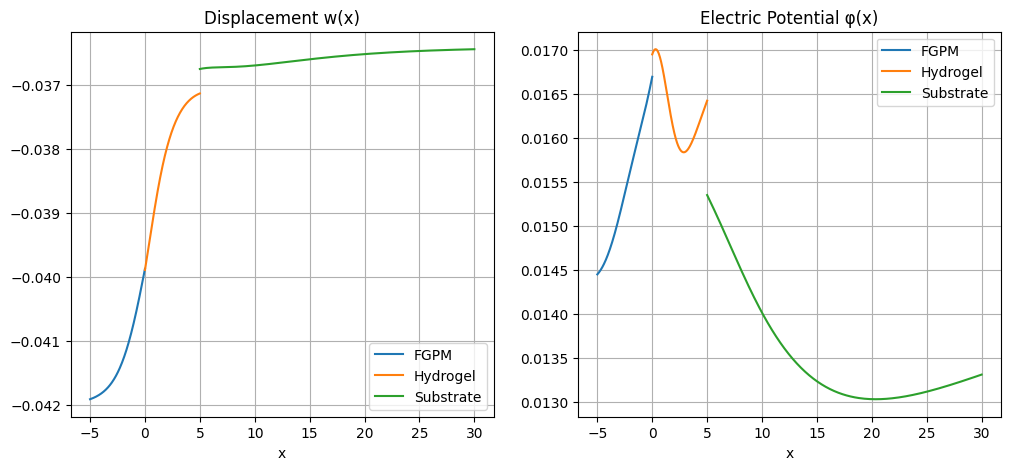

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(x_fgpm.cpu(), w1.cpu(), label="FGPM")
plt.plot(x_hydro.cpu(), w2.cpu(), label="Hydrogel")
plt.plot(x_sub.cpu(), w3.cpu(), label="Substrate")
plt.title("Displacement w(x)")
plt.xlabel("x")
plt.grid(); plt.legend()

plt.subplot(1,2,2)
plt.plot(x_fgpm.cpu(), phi1.cpu(), label="FGPM")
plt.plot(x_hydro.cpu(), phi2.cpu(), label="Hydrogel")
plt.plot(x_sub.cpu(), phi3.cpu(), label="Substrate")
plt.title("Electric Potential φ(x)")
plt.xlabel("x")
plt.grid(); plt.legend()

plt.show()


In [17]:
# x0 = torch.tensor([[0.0, y0, t0]]).to(DEVICE)

# w1_0, phi1_0 = net1(x0).split(1,1)
# w2_0, phi2_0 = net2(x0).split(1,1)

# print("Jump in w at x=0:", (w1_0 - w2_0).item())
# print("Jump in φ at x=0:", (phi1_0 - phi2_0).item())

# xh2 = torch.tensor([[h2, y0, t0]]).to(DEVICE)

# w2_h, phi2_h = net2(xh2).split(1,1)
# w3_h, phi3_h = net3(xh2).split(1,1)

# print("Jump in w at x=h2:", (w2_h - w3_h).item())
# print("Jump in φ at x=h2:", (phi2_h - phi3_h).item())


In [18]:
# x_all = torch.cat([x_fgpm, x_hydro, x_sub], dim=0).cpu()
# w_all = torch.cat([w1, w2, w3], dim=0).cpu()
# phi_all = torch.cat([phi1, phi2, phi3], dim=0).cpu()

# # sort by x
# idx = torch.argsort(x_all.squeeze())
# x_all = x_all[idx]
# w_all = w_all[idx]
# phi_all = phi_all[idx]

# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(x_all, w_all)
# plt.axvline(0, color='k', ls='--')
# plt.axvline(h2, color='k', ls='--')
# plt.title("Displacement w(x)")
# plt.grid()

# plt.subplot(1,2,2)
# plt.plot(x_all, phi_all)
# plt.axvline(0, color='k', ls='--')
# plt.axvline(h2, color='k', ls='--')
# plt.title("Electric potential φ(x)")
# plt.grid()

# plt.show()


Verify Interface & Boundary Conditions
✔ At FGPM–Hydrogel interface 
𝑥
=
0
x=0

In [19]:
x0 = torch.tensor([[0., y0, t0]]).to(DEVICE)

w1_0, phi1_0 = net1(x0).split(1,1)
w2_0, phi2_0 = net2(x0).split(1,1)

print("Jump in w:", (w1_0-w2_0).item())
print("Jump in φ:", (phi1_0-phi2_0).item())


Jump in w: 1.8030405044555664e-05
Jump in φ: -0.00025496073067188263


# At Hydrogel–Substrate 
𝑥
=
ℎ
2
x=h2

In [20]:
xh = torch.tensor([[h2, y0, t0]]).to(DEVICE)

w2_h, phi2_h = net2(xh).split(1,1)
w3_h, phi3_h = net3(xh).split(1,1)

print("Jump in w:", (w2_h-w3_h).item())
print("Jump in φ:", (phi2_h-phi3_h).item())


Jump in w: -0.00038251280784606934
Jump in φ: 0.001073390245437622


# Check Boundary Condition at Top Surface

If electrically open:

In [21]:
from src2.boundary_conditions import top_surface_open_bc
tau, Dx = top_surface_open_bc(net1, torch.tensor([[-h1,y0,t0]]).to(DEVICE), p1)
print(tau.item(), Dx.item())


5.89655501244124e-05 5.896555740037002e-05
